# Import train, validation, test data

In [31]:
import os

#import libraries for data wrangling
import pandas as pd
import numpy as np


#import custom functions for plotting data and calculating metrics
import feature_functions as ff
from little_helpers import *

#import library for SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

#import libraries for parallel processing and error handling
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings

In [5]:
#import train, validation & test data for store number 3
train_df, validation_df, test_df = pd.read_csv('data/train_fil_3.csv',index_col=0),pd.read_csv('data/validation_fil_3.csv',index_col=0),pd.read_csv('data/test_fil_3.csv',index_col=0)
for df in [train_df,validation_df,test_df]:
    df.columns = [int(col) for col in df.columns]
    df.index = pd.to_datetime(df.index)
    
#apply the feature functions to train, validation and test set. Use train as history for validation, so that no NAN values are in beginning of dataframe
x_train, x_validation, x_test = ff.apply_time_featurefun(train_df,column=6), ff.apply_time_featurefun(df=validation_df,column=6,history_df=train_df), ff.apply_time_featurefun(test_df,column=6,history_df=validation_df)

#split dataframes into labels and features
x_train.dropna(inplace=True)
x_validation.dropna(inplace=True)
x_test.dropna(inplace=True)

#seperate features from labels
y_train = x_train.pop('y')
y_validation = x_validation.pop('y')
y_test = x_test.pop('y')

/Users/leo/nf-sep-20/Capstone/capstone/feature_functions.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataframe['lag_'+str(i)] = [get_lagvalue(dataframe['y'][:idx],i) for idx in range(len(dataframe))]
/Users/leo/nf-sep-20/Capstone/capstone/feature_functions.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataframe['weekdaymean_'+str(i)+'_weeks'] = [get_weekdaymean(dataframe['y'][:idx],i) for idx in range(len(dataframe))]
/Users/leo/nf-sep-20/Capstone/capstone/feature_functions.py:7: SettingWithCopyWarning: 
A value is trying to

# Make data stationary and normalize it

# Identify possible values for p,d,q

# Run grid search on SARIMA parameters

In [21]:
# one-step sarima forecast
def sarima_forecast(history, config):
	order, sorder, trend = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(train, test, cfg):
	predictions = list()
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = sarima_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = mape(test, predictions)
	return error

def walk_forward_prediction(train, test, cfg):
	predictions = list()
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = sarima_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	return predictions

# score a model, return None on failure
def score_model(train,test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(train,test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(train,test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(train, test, cfg_list, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(train,test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(train,test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of sarima configs to try
def sarima_configs(seasonal=[0,7]):
	models = list()
	# define config lists
	p_params = [0, 1, 7]
	d_params = [0, 1, 2]
	q_params = [0, 1, 7]
	t_params = ['n','c','t','ct']
	P_params = [0, 1, 2]
	D_params = [0, 1]
	Q_params = [0, 1, 2]
	m_params = seasonal
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p,d,q), (P,D,Q,m), t]
									models.append(cfg)
	return models

In [20]:
if __name__ == '__main__':
	# define dataset
	train = y_train
	test = y_test
	# model configs
	cfg_list = sarima_configs()
	# grid search
	scores = grid_search(train, test, cfg_list,)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
	    print(cfg, error)

KeyboardInterrupt: 

# Save and plot best SARIMA model 

best_sarima = > Model[[(0, 1, 1), (2, 1, 1, 7), 'c']] 9.536

In [34]:
best_params = [(0, 1, 1), (2, 1, 1, 7), 'c']
order, sorder, trend = best_params

model= SARIMAX(y_train,order=order,seasonal_order=sorder,trend=trend)
model.fit()

/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [35]:
y_predict= model.predict(x_validation)

NotImplementedError: 

In [32]:
import pickle
with open('models/3_6_sarima.pkl','wb') as pkl:
    pickle.dump(model,pkl)

In [25]:
y_predict = walk_forward_prediction(y_test,y_validation,[(0, 1, 1), (2, 1, 1, 7), 'c'])

/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum 

/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum 

/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum 

/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum 

/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum 

/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum 

/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum 

/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum 

/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum 

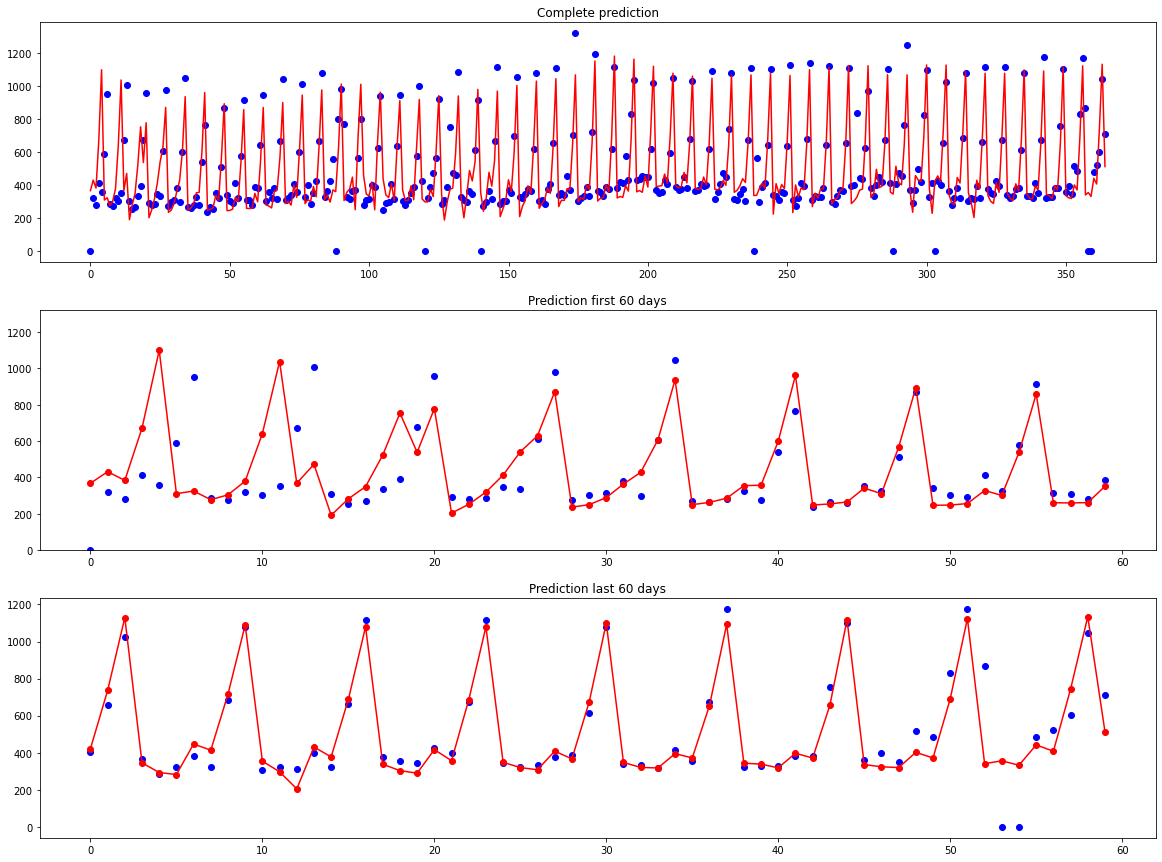

In [26]:
plot_prediction(y_validation,y_predict)

In [27]:
mape(y_validation,y_predict)

14.747099814185784